<center><h1>DSCI-552 HOMEWORK 6</h1><center>
<br>
<center><font size="4"></font></center>
<center><font size="3"><strong>Mason(Mohan) Xing</font></center>
<center><font size="3"><strong>USCID:	6880083372</font></center>

In [1]:
# import dependencies
import warnings
warnings.filterwarnings("ignore")

import os
import urllib
import pandas as pd
import numpy as np
from scipy import stats
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support 
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, pairwise_distances
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.neighbors import KNeighborsClassifier
from scipy.special import softmax
from sklearn.linear_model import SGDClassifier

# check the environment
print (os.environ['CONDA_DEFAULT_ENV'])

dsci552


# 1. Supervised, Semi-Supervised, and Unsupervised Learning

## 1(a) Download the Breast Cancer Wisconsin (Diagnostic) Data Set from:
https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29.
## Download the data in 
https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data, which has IDs, classes (Benign=B, Malignant=M), and 30 attributes. This data has two output classes.

In [2]:
name_file = "../data/wdbc.names"
data_file = "../data/wdbc.data"

Note: The dataset has already been downloaded do not need to run the code below

In [3]:
# # download original dataset
# name_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.names"
# data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
# urllib.request.urlretrieve(name_url, name_file)
# urllib.request.urlretrieve(data_url, data_file)

## 1(b) Monte-Carlo Simulation: 
Repeat the following procedures for supervised, unsupervised, and semi-supervised learning M = 30 times, and use randomly selected train and test data (make sure you use 20% of both the positve and negative classes as the test set). Then compare the average scores (accuracy, precision, recall, F1-score, and AUC) that you obtain from each algorithm.

In [4]:
df_original = pd.read_csv(data_file, header=None)
new_columns = ['code', 'Class'] + ['f{}'.format(i) for i in range(1, len(df_original.columns)-1)]
df_original.columns=new_columns
df_original.info()
df_original.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   code    569 non-null    int64  
 1   Class   569 non-null    object 
 2   f1      569 non-null    float64
 3   f2      569 non-null    float64
 4   f3      569 non-null    float64
 5   f4      569 non-null    float64
 6   f5      569 non-null    float64
 7   f6      569 non-null    float64
 8   f7      569 non-null    float64
 9   f8      569 non-null    float64
 10  f9      569 non-null    float64
 11  f10     569 non-null    float64
 12  f11     569 non-null    float64
 13  f12     569 non-null    float64
 14  f13     569 non-null    float64
 15  f14     569 non-null    float64
 16  f15     569 non-null    float64
 17  f16     569 non-null    float64
 18  f17     569 non-null    float64
 19  f18     569 non-null    float64
 20  f19     569 non-null    float64
 21  f20     569 non-null    float64
 22  f2

,code,Class,f1,f2,f3,f4,f5,f6,f7,f8,...,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
df = df_original.copy()
df_1 = df.drop(columns = 'code')

# label Class column
le = LabelEncoder()
df_1.Class = le.fit_transform(df.Class)

In [6]:
# define function to split train and test data
def tr_ts_split(df, m, ts_ratio, norm = False):
    # select X and y in each class
    X_M = df.loc[df['Class'] == 1].iloc[:, 1:]
    y_M = df.loc[df['Class'] == 1].iloc[:, 0]
    X_B = df.loc[df['Class'] == 0].iloc[:, 1:]
    y_B = df.loc[df['Class'] == 0].iloc[:, 0]
    # split train test data from each class
    X_tr_M, X_ts_M, y_tr_M, y_ts_M = train_test_split(X_M, y_M, test_size=ts_ratio, random_state=m)
    X_tr_B, X_ts_B, y_tr_B, y_ts_B = train_test_split(X_B, y_B, test_size=ts_ratio, random_state=m)
    # Generate train and test data
    X_tr = pd.concat([X_tr_M, X_tr_B]).sort_index()
    y_tr = pd.concat([y_tr_M, y_tr_B]).sort_index()
    X_ts = pd.concat([X_ts_M, X_ts_B]).sort_index()
    y_ts = pd.concat([y_ts_M, y_ts_B]).sort_index()
    
    if norm == True:
        scaler = MinMaxScaler()
        X_tr_std = pd.DataFrame(scaler.fit_transform(X_tr), columns=X_tr.columns, index=y_tr.index)
        X_ts_std = pd.DataFrame(scaler.transform(X_ts), columns=X_ts.columns, index=y_ts.index)
        
        return X_tr_std, X_ts_std, y_tr, y_ts

    else:
        
        return X_tr, X_ts, y_tr, y_ts

In [7]:
# define function to evaluate prediction
def evaluation(y_tr, y_pred, y_prob, average):
    '''
    average{'binary', 'micro', 'macro', 'samples','weighted'}, default=None
    
    '''
    result ={}
    result['accuracy'] = accuracy_score(y_tr, y_pred)
    result['precision'] = precision_recall_fscore_support(y_tr, y_pred, average=average)[0]
    result['recall'] = precision_recall_fscore_support(y_tr, y_pred, average=average)[1]
    result['fscore'] = precision_recall_fscore_support(y_tr, y_pred, average=average)[2]
    
    if len(y_prob) != 0:
        fpr, tpr, thresholds = roc_curve(y_tr, y_prob, pos_label=1)
        result['AUC'] = auc(fpr, tpr)
        
    return result

In [8]:
# define function to calculate and plot confusion matrix
def cm(y_true, y_pred, title):
    
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['B', 'M'])
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_title("{} Set Confustion Matrix".format(title), fontsize=16)
    disp.plot(ax=ax)
    plt.show()

In [9]:
# define roc curve plot function
def roc(y_true, y_score, title):
    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)
    roc_auc = auc(fpr, tpr)
    print("AUC is" , roc_auc)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.6f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.grid()
    plt.xlim([-0.05, 1])
    plt.ylim([0.0, 1.05])
    plt.legend(loc="lower right")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.show()

In [10]:
# define a function to calculate svm result
def svm_result(model, X_tr, X_ts, y_tr, y_ts):
    
    result = {}
    result['y_tr'] = y_tr
    result['y_tr_pred'] = model.predict(X_tr)
    result['y_tr_score'] = model.decision_function(X_tr)
    result['y_ts'] = y_ts
    result['y_ts_pred'] = model.predict(X_ts)
    result['y_ts_score'] = model.decision_function(X_ts)
    
    return result

### 1(b) i. Supervised Learning: Train an L1-penalized SVM to classify the data.
Use 5 fold cross validation to choose the penalty parameter. Use normalized data. Report the average accuracy, precision, recall, F1-score, and AUC, for both training and test sets over your M runs. Plot the ROC and report the confusion matrix for training and testing in one of the runs. <br>
ref: https://stackoverflow.com/questions/31159157/different-result-with-roc-auc-score-and-auc<br>

In [11]:
# define SVM model tuning hyperparameters
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
steps = [('scaler', MinMaxScaler()), ('LinearSVC', LinearSVC(penalty = 'l1', dual=False, max_iter=1e5))]
pipeline = Pipeline(steps)
parameters = {'LinearSVC__C':np.logspace(-3,6,10)}
grid_sl = GridSearchCV(pipeline, param_grid = parameters, scoring='accuracy', cv=skf, n_jobs=-1)

* Monte-Carlo Simulation:

In [12]:
clf_results = []
tr_evals = []
ts_evals = []

for m in tqdm(range(30)):
    
    X_train, X_test, y_train, y_test = tr_ts_split(df_1, m, ts_ratio=0.2)
    
    # fit model get prediction results
    grid_sl.fit(X_train, y_train)
    clf_result = svm_result(grid_sl, X_train, X_test, y_train, y_test)
    # evaluate model
    tr_eval = evaluation(y_train, clf_result['y_tr_pred'], clf_result['y_tr_score'], average='binary')
    ts_eval = evaluation(y_test, clf_result['y_ts_pred'], clf_result['y_ts_score'], average='binary')
    # save results
    clf_results.append(clf_result)
    tr_evals.append(tr_eval)
    ts_evals.append(ts_eval)
#convert saved results to df    
# prediction result
clf_1bi_df =  pd.DataFrame.from_dict(clf_results, orient='columns')
# evaluation result
tr_eval_1bi = pd.DataFrame.from_dict(tr_evals, orient='columns')
ts_eval_1bi = pd.DataFrame.from_dict(ts_evals, orient='columns')

100%|██████████| 30/30 [00:53<00:00,  1.78s/it]


* Report the average accuracy, precision, recall, F1-score, and AUC, for both training and test sets over your M runs

In [13]:
# Train result
print('='*80)
print('The average metrics for training set over 30 Monte-Carlo simulations are:')
print('='*80)
df_1bi_tr = pd.DataFrame(tr_eval_1bi.mean()).T
df_1bi_tr.index=['Supervised Learning Train']
print(df_1bi_tr.T)
print('='*80)

# Test result
print('='*80)
print('The average metrics for test set over 30 Monte-Carlo simulations are:')
print('='*80)
df_1bi_ts = pd.DataFrame(ts_eval_1bi.mean()).T
df_1bi_ts.index=['Supervised Learning Test']
print(df_1bi_ts.T)
print('='*80)

The average metrics for training set over 30 Monte-Carlo simulations are:
           Supervised Learning Train
accuracy                    0.985242
precision                   0.989347
recall                      0.970809
fscore                      0.979967
AUC                         0.997444
The average metrics for test set over 30 Monte-Carlo simulations are:
           Supervised Learning Test
accuracy                   0.971884
precision                  0.980392
recall                     0.944186
fscore                     0.961346
AUC                        0.991570


* Plot the ROC and report the confusion matrix for training and testing in one of the runs
#### - Training Set

[[282   3]
 [  7 162]]


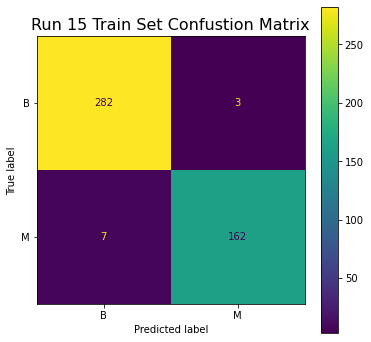

AUC is 0.9968234194954843


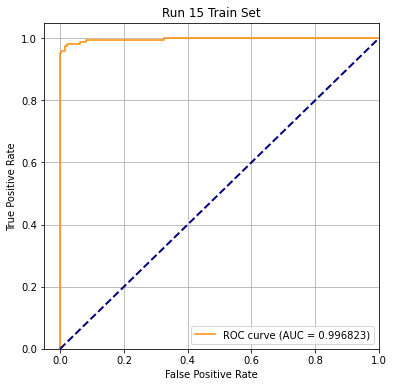

In [14]:
run = 15
cm(clf_1bi_df.loc[run]['y_tr'], clf_1bi_df.loc[run]['y_tr_pred'], 'Run {} Train'.format(run))
roc(clf_1bi_df.loc[run]['y_tr'], clf_1bi_df.loc[run]['y_tr_score'], 'Run {} Train Set'.format(run))

#### - Test Set

[[71  1]
 [ 1 42]]


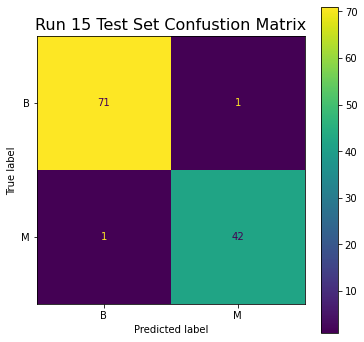

AUC is 0.9974160206718347


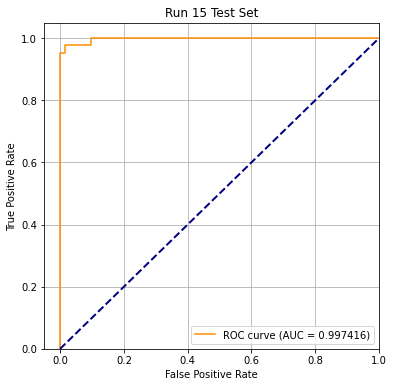

In [15]:
cm(clf_1bi_df.loc[run]['y_ts'], clf_1bi_df.loc[run]['y_ts_pred'], 'Run {} Test'.format(run))
roc(clf_1bi_df.loc[run]['y_ts'], clf_1bi_df.loc[run]['y_ts_score'], 'Run {} Test Set'.format(run))

### 1(b) ii. Semi-Supervised Learning/ Self-training:
select 50% of the positive class along with 50% of the negative class in the training set as labeled data and the rest as unlabelled data. You can select them randomly.

#### 1(b) ii. A Train an L1-penalized SVM to classify the labeled data Use normalized data. Choose the penalty parameter using 5 fold cross validation.

In [16]:
# define SVM model tuning hyperparameters
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
steps = [('scaler', MinMaxScaler()), ('LinearSVC', LinearSVC(penalty = 'l1', dual=False, max_iter=1e7))]
pipeline = Pipeline(steps)
parameters = {'LinearSVC__C':np.logspace(-3,6,10)}
grid_ssl = GridSearchCV(pipeline, param_grid = parameters, scoring='accuracy', cv=skf, n_jobs=-1)

#### 1(b) ii. B Find the unlabeled data point that is the farthest to the decision boundary of the SVM. 
Let the SVM label it (ignore its true label), and add it to the labeled data, and retrain the SVM. Continue this process until all unlabeled data are used. Test the final SVM on the test data andthe average accuracy, precision, recall, F1-score, and AUC, for both training and test sets over your M runs. Plot the ROC and report the confusion
matrix for training and testing in one of the runs. <br>
ref: https://stackoverflow.com/questions/32074239/sklearn-getting-distance-of-each-point-from-decision-boundary

#### 1(b) ii. A and 1(b) ii. B
* Monte-Carlo Simulation:

In [17]:
clf_results = []
tr_evals = []
ts_evals = []

for m in tqdm(range(30)):
    
    # define train and test data
    X_train, X_test, y_train, y_test = tr_ts_split(df_1, m, ts_ratio=0.2)
    # define initial label and unlabelled data
    train = pd.concat([y_train, X_train], axis = 1)
    X_label, X_unlabelled, y_label, y_unlabelled = tr_ts_split(train, m, ts_ratio=0.5)
    # 1biiA choose the best estimator of the initial model
    grid_ssl.fit(X_label, y_label)

    while X_unlabelled.shape[0] > 0:
        
        #label unlabelled data
        y_pred_temp = grid_ssl.predict(X_unlabelled)
        # calculate the distance to hyperplane
        y_score = grid_ssl.decision_function(X_unlabelled)
        w_norm = np.linalg.norm(grid_ssl.best_estimator_['LinearSVC'].coef_)
        dist = y_score / w_norm
        # get the index of the fartest point
        maxd_index = np.argmax(np.abs(dist))
        row_index = X_unlabelled.index[maxd_index]
        # add labeled data to labeled pool
        X_label = X_label.append(X_unlabelled.loc[row_index])
        y_label = y_label.append(pd.Series(y_pred_temp[maxd_index], index =[row_index]))
        # drop a labeled data point in unlabelled data
        X_unlabelled = X_unlabelled.drop([row_index])
        y_unlabelled = y_unlabelled.drop([row_index])
        grid_ssl.fit(X_label, y_label)
    
    # obtain prediction and evaluation results
    clf_result = svm_result(grid_ssl, X_train, X_test, y_train, y_test)
    clf_results.append(clf_result)
    # evaluate train and test set                     
    tr_eval = evaluation(y_train, clf_result['y_tr_pred'], clf_result['y_tr_score'], average='binary')
    ts_eval = evaluation(y_test, clf_result['y_ts_pred'], clf_result['y_ts_score'], average='binary')
    tr_evals.append(tr_eval)
    ts_evals.append(ts_eval)
    
# convert saved results to df
# prediction result
clf_1bii_df =  pd.DataFrame.from_dict(clf_results, orient='columns')
# evaluation result
tr_eval_1bii = pd.DataFrame.from_dict(tr_evals, orient='columns')
ts_eval_1bii = pd.DataFrame.from_dict(ts_evals, orient='columns')

100%|██████████| 30/30 [40:02<00:00, 80.09s/it] 


* Report the average accuracy, precision, recall, F1-score, and AUC, for both training and test sets over your M runs

In [18]:
# training set
print('='*80)
print('The average metrics for training set over 30 Monte-Carlo simulations are:')
print('='*80)
df_1bii_tr = pd.DataFrame(tr_eval_1bii.mean()).T
df_1bii_tr.index=['Semi-Supervised Learning Train']
print(df_1bii_tr.T)
print('='*80)

# test set
print('='*80)
print('The average metrics for test set over 30 Monte-Carlo simulations are:')
print('='*80)
df_1bii_ts = pd.DataFrame(ts_eval_1bii.mean()).T
df_1bii_ts.index=['Semi-Supervised Learning Test']
print(df_1bii_ts.T)
print('='*80)

The average metrics for training set over 30 Monte-Carlo simulations are:
           Semi-Supervised Learning Train
accuracy                         0.976579
precision                        0.984874
recall                           0.951874
fscore                           0.967938
AUC                              0.994069
The average metrics for test set over 30 Monte-Carlo simulations are:
           Semi-Supervised Learning Test
accuracy                        0.964348
precision                       0.974511
recall                          0.929457
fscore                          0.950840
AUC                             0.987715


* Plot the ROC and report the confusion matrix for training and testing in one of the runs
#### - Training Set

[[282   3]
 [  9 160]]


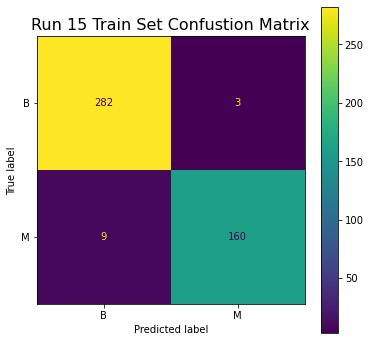

AUC is 0.989183016713381


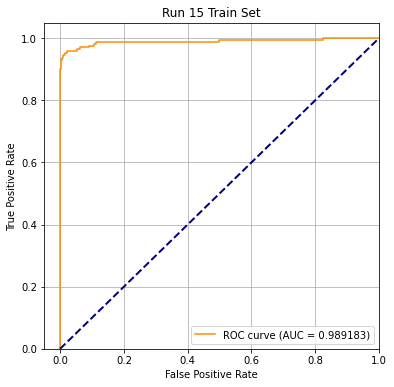

In [19]:
run = 15
cm(clf_1bii_df.loc[run]['y_tr'], clf_1bii_df.loc[run]['y_tr_pred'], 'Run {} Train'.format(run))
roc(clf_1bii_df.loc[run]['y_tr'], clf_1bii_df.loc[run]['y_tr_score'], 'Run {} Train Set'.format(run))

#### - Test Set

[[71  1]
 [ 4 39]]


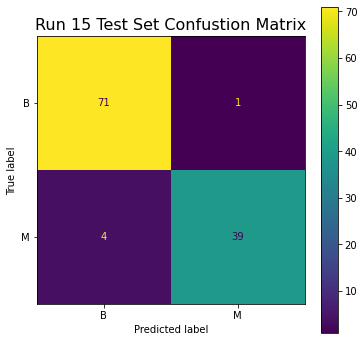

AUC is 0.9906330749354005


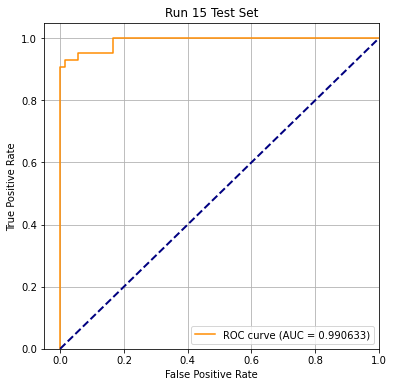

In [20]:
cm(clf_1bii_df.loc[run]['y_ts'], clf_1bii_df.loc[run]['y_ts_pred'], 'Run {} Test'.format(run))
roc(clf_1bii_df.loc[run]['y_ts'], clf_1bii_df.loc[run]['y_ts_score'], 'Run {} Test Set'.format(run))

### 1(b) iii. Unsupervised Learning: 
Run k-means algorithm on the whole training set. Ignore the labels of the data, and assume k = 2.
#### 1(b) iii. A. Run the k-means algorithm multiple times. 
Make sure that you initialize the algoritm randomly. How do you make sure that the algorithm was not trapped in a local minimum?<br>
ref: http://ethen8181.github.io/machine-learning/clustering/kmeans.html <br>
ref: https://stackoverflow.com/questions/54240144/distance-between-nodes-and-the-centroid-in-a-kmeans-cluster<br>
ref: https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.softmax.html<br>
ref: https://stackoverflow.com/questions/26795535/output-50-samples-closest-to-each-cluster-center-using-scikit-learn-k-means-libr<br>
ref: https://datascience.stackexchange.com/questions/6715/is-it-necessary-to-standardize-your-data-before-clustering<br>

<strong>Answer</strong><br>
In order to avoid trapping in a a local minimum, at the beginning we assign cluster randomly, we can increase the 
number of time the k-means algorithm run with different centroid seeds(initial condition). And choose the final cluster has the lowest within cluster variation.

#### 1(b) iii. B. Compute the centers of the two clusters and find the closest 30 data points to each center. 
Read the true labels of those 30 data points and take a majority poll within them. The majority poll becomes the label
predicted by k-means for the members of each cluster. Then compare the labels provided by k-means with the true labels of the training data and report the average accuracy, precision, recall, F1-score, and AUC over M runs, and ROC and the confusion matrix for one of the runs.

In [21]:
# define a function to assign predict label for each cluster based on distance to center
def assign_label(dist, cluster_label, y_tr):
    '''
    dist: training data dist
    y_tr: train set label column
    
    '''
    index_cl0 = np.argsort(dist[:,0])[:30]
    index_cl1 = np.argsort(dist[:,1])[:30]
    mode_cl0 = stats.mode(y_tr.values[index_cl0])[0][0]
    mode_cl1 = stats.mode(y_tr.values[index_cl1])[0][0]
    y_pred = np.array([mode_cl0 if x==0 else mode_cl1 for x in cluster_label])
    if mode_cl0 != 0 :# model pos label is at cluster[0]
        pos_dist_index = 1
    else:
        pos_dist_index = 0
    return y_pred, pos_dist_index

In [22]:
tr_evals = []
ts_evals = []
results = []
for m in tqdm(range(30)):
    
    X_train, X_test, y_train, y_test = tr_ts_split(df_1, m, ts_ratio=0.2, norm=True)
#     X_train, X_test, y_train, y_test = tr_ts_split(df_1, m, ts_ratio=0.2)
    # run kmeans multiple times with a large n_init
    clusterer = KMeans(n_clusters=2, n_init=100, random_state=m)
    clusterer.fit(X_train)
    # train set prediction
    cl_tr =  clusterer.predict(X_train)
    tr_dist = clusterer.transform(X_train)
    y_tr_pred, pos_tr_index = assign_label(tr_dist, cl_tr, y_train)
    y_tr_prob = softmax(tr_dist, axis=1)[:,pos_tr_index]
    # test set prediction
    cl_ts =  clusterer.predict(X_test)
    ts_dist = clusterer.transform(X_test)
    y_ts_pred, pos_ts_index = assign_label(tr_dist, cl_ts, y_train)
    y_ts_prob = softmax(ts_dist, axis=1)[:,pos_ts_index]
    
    # save results to list of dicts
    result = {}
    result['y_tr'] = y_train
    result['y_tr_pred'] = y_tr_pred
    result['y_tr_prob'] = y_tr_prob
    result['y_ts'] = y_test
    result['y_ts_pred'] = y_ts_pred
    result['y_ts_prob'] = y_ts_prob
    results.append(result)
    # evaluate train and test set
    tr_eval = evaluation(y_train, y_tr_pred, y_tr_prob, average='binary')
    ts_eval = evaluation(y_test, y_ts_pred, y_ts_prob, average='binary')
    tr_evals.append(tr_eval)
    ts_evals.append(ts_eval)

#convert saved results to df 
# prediction result
clf_1biii_df =  pd.DataFrame.from_dict(results, orient='columns')
# evaluation result
tr_eval_1biii = pd.DataFrame.from_dict(tr_evals, orient='columns')
ts_eval_1biii = pd.DataFrame.from_dict(ts_evals, orient='columns')

100%|██████████| 30/30 [00:08<00:00,  3.39it/s]


* Report the average accuracy, precision, recall, F1-score, and AUC, for both training and test sets over your M runs

In [23]:
# train set
print('='*80)
print('The average metrics for training set over 30 Monte-Carlo simulations are:')
print('='*80)
df_1biii_tr = pd.DataFrame(tr_eval_1biii.mean()).T
df_1biii_tr.index=['Unsupervised Learning-Kmean Cluster Train']
print(df_1biii_tr.T)
print('='*80)

The average metrics for training set over 30 Monte-Carlo simulations are:
           Unsupervised Learning-Kmean Cluster Train
accuracy                                    0.925771
precision                                   0.948442
recall                                      0.846943
fscore                                      0.894641
AUC                                         0.979405


* Plot the ROC and report the confusion matrix for training and testing in one of the runs

[[278   7]
 [ 26 143]]


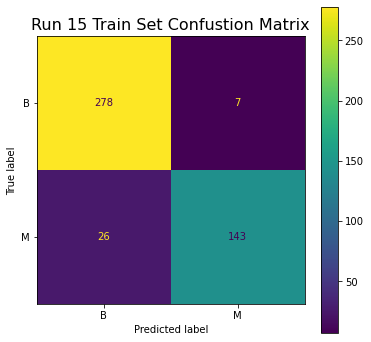

AUC is 0.9827260458839406


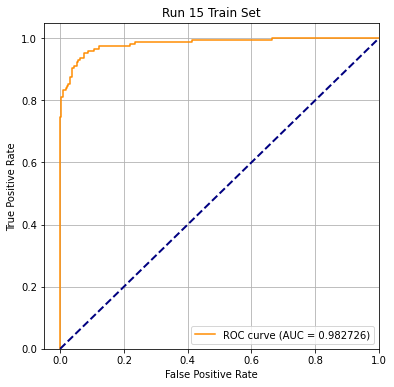

In [24]:
run = 15
# confusion matrix
cm(clf_1biii_df.loc[run]['y_tr'], clf_1biii_df.loc[run]['y_tr_pred'], 'Run {} Train'.format(run))
# roc curve
roc(clf_1biii_df.loc[run]['y_tr'], clf_1biii_df.loc[run]['y_tr_prob'], 'Run {} Train Set'.format(run))

#### 1(b) iii. C. Classify test data based on their proximity to the centers of the clusters. 
Report the average accuracy, precision, recall, F1-score, and AUC over M runs, and ROC and the confusion matrix for one of the runs for the test data.

In [25]:
# test set
print('='*80)
print('The average metrics for test set over 30 Monte-Carlo simulations are:')
print('='*80)
df_1biii_ts = pd.DataFrame(ts_eval_1biii.mean()).T
df_1biii_ts.index=['Unsupervised Learning Learning-Kmean Cluster Test']
print(df_1biii_ts.T)
print('='*80)

The average metrics for test set over 30 Monte-Carlo simulations are:
           Unsupervised Learning Learning-Kmean Cluster Test
accuracy                                            0.924928
precision                                           0.946520
recall                                              0.847287
fscore                                              0.893527
AUC                                                 0.982052


[[67  5]
 [ 6 37]]


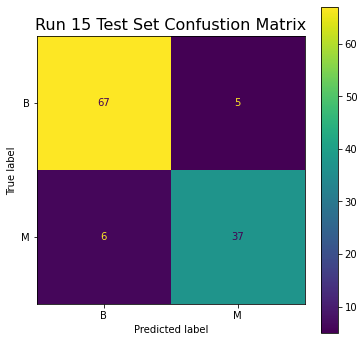

AUC is 0.9680232558139535


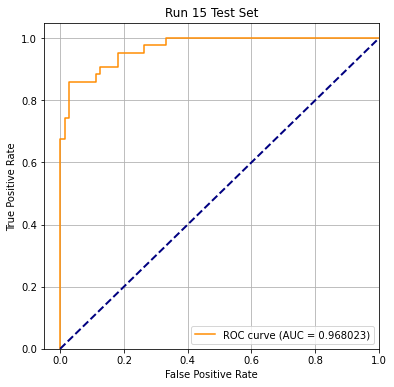

In [26]:
cm(clf_1biii_df.loc[run]['y_ts'], clf_1biii_df.loc[run]['y_ts_pred'], 'Run {} Test'.format(run))
roc(clf_1biii_df.loc[run]['y_ts'], clf_1biii_df.loc[run]['y_ts_prob'], 'Run {} Test Set'.format(run))

### 1(b) iv. Spectral Clustering: 
Repeat 1(b)iii using spectral clustering, which is clustering based on kernels. Research what spectral clustering is. Use RBF kernel with gamma=1 or find a gamma for which the two clutsres have the same balance as the one in original data set (if the positive class has p and the negative class has n samples, the two clusters must have p and n members). Do not label data based on their proximity to cluster center, because spectral clustering may give you non-convex clusters . Instead, use fit-predict method.

ref: https://scikit-learn.org/stable/modules/clustering.html#spectral-clustering <br>
ref: https://stackoverflow.com/questions/61321778/how-to-calculate-tpr-and-fpr-in-python-without-using-sklearn

<strong>Answer</strong><br>
SpectralClustering performs a low-dimension embedding of the affinity matrix between samples, followed by clustering, e.g., by KMeans, of the components of the eigenvectors in the low dimensional space. It is especially computationally efficient if the affinity matrix is sparse

In [27]:
# define a majority polling function based on different threshold
def get_majority(cluster_label, y_true, threshold, num_data='all'):
    '''
    cluster_label : cluster_labels
    y_true: true labels
    threshold: 0.5 for normal binary class majority polling
    
    '''
    if type(num_data) == int:
        select_cl = np.random.choice(cluster_label, num_data, replace=False)
        index_cl0 = np.where(select_cl==0)
        index_cl1 = np.where(select_cl==1)
    else:
        index_cl0 = np.where(cluster_label==0)
        index_cl1 = np.where(cluster_label==1)
    
    cl0 = y_true.values[index_cl0]
    cl1 = y_true.values[index_cl1]
    
    cl0_num_ones = (cl0 == 1).sum()
    cl1_num_ones = (cl1 == 1).sum()
    # Assign cluster 0 based on true value
    if cl0_num_ones > len(cl0)*threshold:
        label0 = 1
    else:
        label0 = 0
    # Assign cluster 1 based on true value   
    if cl1_num_ones > len(cl1)*threshold:
        label1 = 1
    else:
        label1 = 0
    y_pred = np.where(cluster_label==0, label0, label1)
    
    return y_pred

In [28]:
# calculate tpr and fpr at given threshold
def calculate_at_threshold(threshold, y_true, cluster_label):
    
    y_pred = get_majority(cluster_label, y_true, threshold)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    # calculate recall
    tpr = (tp)/(tp + fn)
    # calculate fallout
    fpr = (fp)/(fp + tn)
    
    return fpr, tpr

In [29]:
# define a function to calcuate tpr and fpr at different threshold
def get_roc_curve(y_true, cluster_label):
    
    tpr =[]
    fpr = []
    thresholds = np.linspace(0,1,11)
    for threshold in thresholds:
        fpr_t, tpr_t = calculate_at_threshold(threshold, y_true, cluster_label)
        fpr.append(fpr_t)
        tpr.append(tpr_t)
        
    return fpr, tpr

In [30]:
# define plot roc curve function
def roc_cluster(fpr, tpr, title):

    roc_auc = auc(fpr, tpr)
    print("AUC is" , roc_auc)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.6f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.grid()
    plt.xlim([-0.05, 1])
    plt.ylim([0.0, 1.05])
    plt.legend(loc="lower right")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.show()

In [31]:
clustering = SpectralClustering(n_clusters=2, n_init=100, gamma=1,
                                assign_labels='discretize', #The strategy for assigning labels in the embedding space
                                affinity = 'rbf', 
                                random_state=m,
                                n_jobs = -1)

In [32]:
results = []
tr_evals = []
ts_evals = []
tr_aucs = []
ts_aucs = []
for m in tqdm(range(30)):
    
    X_train, X_test, y_train, y_test = tr_ts_split(df_1, m, ts_ratio=0.2, norm=True)
    # obtain cluster labels of train set
    tr_cl = clustering.fit_predict(X_train)
    y_tr_pred = get_majority(tr_cl, y_train, 0.5, num_data='all')
    tr_fpr, tr_tpr = get_roc_curve(y_train, tr_cl)
    tr_aucs.append(auc(tr_fpr, tr_tpr))
    
    # obtain cluster labels of test set
    # build a KNN classifier based on training data
    knn = KNeighborsClassifier(n_neighbors=1, n_jobs =-1)
    knn.fit(X_train.values, tr_cl)
    ts_cl = knn.predict(X_test.values)
    y_ts_pred = get_majority(ts_cl, y_test, 0.5, num_data='all')
    ts_fpr, ts_tpr = get_roc_curve(y_test, ts_cl)
    ts_aucs.append(auc(ts_fpr, ts_tpr))
    
    # save results to list of dicts
    result = {}
    result['y_tr'] = y_train
    result['y_tr_pred'] = y_tr_pred
    result['tr_fpr'] = tr_fpr
    result['tr_tpr'] = tr_tpr
    result['y_ts'] = y_test
    result['y_ts_pred'] = y_ts_pred
    result['ts_fpr'] = ts_fpr
    result['ts_tpr'] = ts_tpr
    results.append(result)
    #evaluate train and test set
    tr_eval = evaluation(y_train, y_tr_pred, y_prob=[], average='binary')
    ts_eval = evaluation(y_test, y_ts_pred, y_prob=[], average='binary')
    tr_evals.append(tr_eval)
    ts_evals.append(ts_eval)
    
    
    
# prediction result
clf_1biv_df =  pd.DataFrame.from_dict(results, orient='columns')
# evaluation result
tr_eval_1biv = pd.DataFrame.from_dict(tr_evals, orient='columns')
tr_eval_1biv['AUC'] = tr_aucs
ts_eval_1biv = pd.DataFrame.from_dict(ts_evals, orient='columns')
ts_eval_1biv['AUC'] = ts_aucs

100%|██████████| 30/30 [00:01<00:00, 19.69it/s]


* Report the average accuracy, precision, recall, F1-score, and AUC, for both training and test sets over your M runs

In [33]:
print('='*80)
print('The average metrics for training set over 30 Monte-Carlo simulations are:')
print('='*80)
df_1biv_tr = pd.DataFrame(tr_eval_1biv.mean()).T
df_1biv_tr.index=['Unsupervised Learning-Spectral Clustering Train']
print(df_1biv_tr.T)
print('='*80)
print('The average metrics for test set over 30 Monte-Carlo simulations are:')
print('='*80)
df_1biv_ts = pd.DataFrame(ts_eval_1biv.mean()).T
df_1biv_ts.index=['Unsupervised Learning-Spectral Clustering Test']
print(df_1biv_ts.T)
print('='*80)

The average metrics for training set over 30 Monte-Carlo simulations are:
           Unsupervised Learning-Spectral Clustering Train
accuracy                                          0.915859
precision                                         0.979259
recall                                            0.790927
fscore                                            0.874571
AUC                                               0.890434
The average metrics for test set over 30 Monte-Carlo simulations are:
           Unsupervised Learning-Spectral Clustering Test
accuracy                                         0.917391
precision                                        0.988442
recall                                           0.788372
fscore                                           0.876162
AUC                                              0.891408


* Plot the ROC and report the confusion matrix for training and testing in one of the runs
#### - Train Set

[[284   1]
 [ 35 134]]


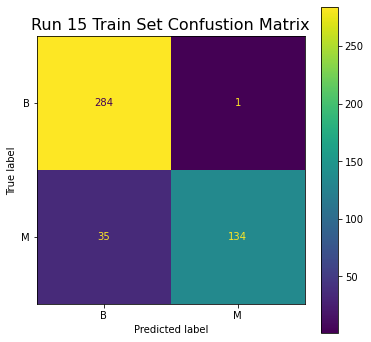

AUC is 0.8946953181770996


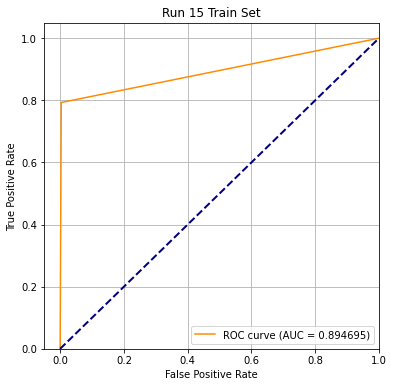

In [34]:
m = 15
cm(clf_1biv_df.loc[run]['y_tr'], clf_1biv_df.loc[run]['y_tr_pred'], 'Run {} Train'.format(run))
sample_tr_fpr = clf_1biv_df.loc[run]['tr_fpr']
sample_tr_tpr = clf_1biv_df.loc[run]['tr_tpr']
roc_cluster(sample_tr_fpr, sample_tr_tpr, 'Run {} Train Set'.format(run))

#### - Test Set

[[71  1]
 [10 33]]


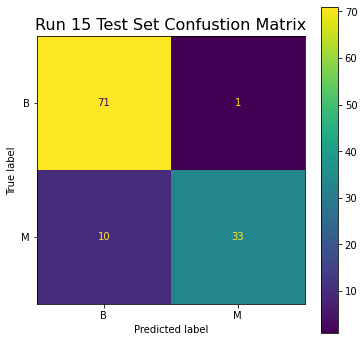

AUC is 0.8767764857881137


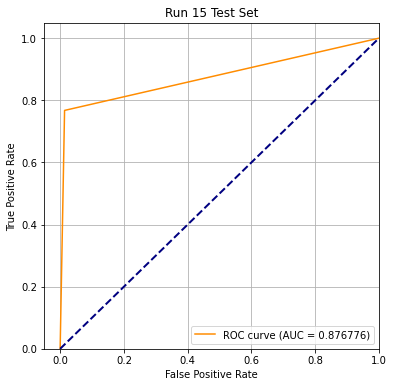

In [35]:
cm(clf_1biv_df.loc[run]['y_ts'], clf_1biv_df.loc[run]['y_ts_pred'], 'Run {} Test'.format(run))
sample_ts_fpr = clf_1biv_df.loc[run]['ts_fpr']
sample_ts_tpr = clf_1biv_df.loc[run]['ts_tpr']
roc_cluster(sample_ts_fpr, sample_ts_tpr, 'Run {} Test Set'.format(run))

### 1(b) v.  Compare the results you obtained by those methods.
* Train Set 

In [36]:
df_1bv_tr = pd.concat([df_1bi_tr, df_1bii_tr, df_1biii_tr, df_1biv_tr])
df_1bv_tr

,accuracy,precision,recall,fscore,AUC
Supervised Learning Train,0.985242,0.989347,0.970809,0.979967,0.997444
Semi-Supervised Learning Train,0.976579,0.984874,0.951874,0.967938,0.994069
Unsupervised Learning-Kmean Cluster Train,0.925771,0.948442,0.846943,0.894641,0.979405
Unsupervised Learning-Spectral Clustering Train,0.915859,0.979259,0.790927,0.874571,0.890434


* Test Set 

In [37]:
df_1bv_ts = pd.concat([df_1bi_ts, df_1bii_ts, df_1biii_ts, df_1biv_ts])
df_1bv_ts

,accuracy,precision,recall,fscore,AUC
Supervised Learning Test,0.971884,0.980392,0.944186,0.961346,0.991570
Semi-Supervised Learning Test,0.964348,0.974511,0.929457,0.950840,0.987715
Unsupervised Learning Learning-Kmean Cluster Test,0.924928,0.946520,0.847287,0.893527,0.982052
Unsupervised Learning-Spectral Clustering Test,0.917391,0.988442,0.788372,0.876162,0.891408


<strong>Summary</strong><br>
* In general, based on both train and test evaluation reports, Supervised and Semi-Supervised Learning performed better than the Unsupervised Learning and Spectral Clustering.
* The evaluation result of all metrics of Supervised Learning on both training and test sets are better than Semi-Supervised Learning. Since Supervised Learning is training by the entrie dataset.
* The performance of Spectral Clustering is worse than Kmean Clustering  on test set.However the precision is higher than kmeans.
* The results confirms "One can expect that supervised learning on the full data set works better than semi-supervised learning with half of the data set labeled.One can expect that unsupervised learning underperforms in such situations.

# 2. Active Learning Using Support Vector Machines
## 2(a) Download the banknote authentication Data Set
from: https://archive.ics.uci.edu/ml/datasets/banknote+authentication. Choose 472 data points randomly as the test set, and the remaining 900 points as the training set. This is a binary classification problem.

In [38]:
data_file2 = "../data/data_banknote_authentication.txt"

In [39]:
# # download original dataset
# data_url2 = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"
# urllib.request.urlretrieve(data_url2, data_file2)

In [40]:
data_original = pd.read_csv(data_file2, header=None)
df_2 = data_original.copy()
new_columns = ['variance','skewness','curtosis','entropy', 'Class']
df_2.columns=new_columns
df_2.info()
df_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   curtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   Class     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


,variance,skewness,curtosis,entropy,Class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [41]:
print(df_2.Class.value_counts())

0    762
1    610
Name: Class, dtype: int64


In [42]:
def data_prepare(df, m, norm=False):
    '''
    df: dataset
    m : random state
    '''
    
    X = df.iloc[:,0:-1]
    y = df.iloc[:,-1]
    
    X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size= 472, stratify=y, random_state= m)
    
    if norm == True:
        scaler = MinMaxScaler()
        X_tr_std = pd.DataFrame(scaler.fit_transform(X_tr), columns=X_tr.columns, index=y_tr.index)
        X_ts_std = pd.DataFrame(scaler.transform(X_ts), columns=X_ts.columns, index=y_ts.index)
        
        return X_tr_std, X_ts_std, y_tr, y_ts
    
    return X_tr, X_ts, y_tr, y_ts

## 2(b) Repeat each of the following two procedures 50 times. 
You will have 50 errors for 90 SVMs per each procedure.
### 2(b) i. Passive Learning

In [43]:
# define SVM model tuning hyperparameters
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
steps = [('scaler', MinMaxScaler()), ('LinearSVC', LinearSVC(penalty = 'l1', dual=False, max_iter=1e7))]
pipeline = Pipeline(steps)
parameters = {'LinearSVC__C':np.logspace(-3,6,10)}
grid_pl = GridSearchCV(pipeline, param_grid = parameters, scoring='accuracy', cv=skf, n_jobs=-1)

In [44]:
result = {}
for m in tqdm(range(0,50)):
    
    X_train, X_test, y_train, y_test = data_prepare(df_2, 42)
    X_pool = pd.DataFrame()
    y_pool = pd.Series(dtype='float64')

    X_train_remain = X_train.copy()
    y_train_remain = y_train.copy()
    errors =[]
    for i in range(90):
        
        if X_train_remain.shape[0] == 10:
            X_select = X_train_remain
            y_select = y_train_remain
        else:
            X_train_remain, X_select, y_train_remain, y_select = train_test_split(X_train_remain, y_train_remain, 
                                                                stratify=y_train_remain, test_size=10, random_state=m)
            
        # add samples to the pool   
        X_pool = X_pool.append(X_select)
        y_pool = y_pool.append(y_select)
        # Apply Gridsearch CV
        grid_pl.fit(X_pool, y_pool)
        y_test_pred = grid_pl.predict(X_test)
        error = 1 - accuracy_score(y_test, y_test_pred)
        # save result
        errors.append(error)
    result[m] = errors
df_2bi =pd.DataFrame.from_dict(result).T

100%|██████████| 50/50 [28:49<00:00, 34.59s/it]


* Sample result:

In [45]:
df_2bi.columns = ['{} samples'.format(i) for i in range(10,910,10)]
df_2bi.head()

,10 samples,20 samples,30 samples,40 samples,50 samples,60 samples,70 samples,80 samples,90 samples,100 samples,...,810 samples,820 samples,830 samples,840 samples,850 samples,860 samples,870 samples,880 samples,890 samples,900 samples
0,0.076271,0.038136,0.040254,0.019068,0.019068,0.019068,0.008475,0.008475,0.012712,0.012712,...,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.012712,0.008475,0.008475
1,0.197034,0.156780,0.120763,0.031780,0.027542,0.025424,0.012712,0.008475,0.014831,0.008475,...,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475
2,0.326271,0.103814,0.029661,0.019068,0.025424,0.029661,0.033898,0.014831,0.023305,0.023305,...,0.008475,0.008475,0.012712,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475
3,0.171610,0.139831,0.012712,0.118644,0.031780,0.025424,0.027542,0.044492,0.055085,0.052966,...,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.012712,0.008475,0.008475,0.008475
4,0.059322,0.044492,0.029661,0.072034,0.012712,0.019068,0.023305,0.023305,0.012712,0.008475,...,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.012712,0.012712,0.008475,0.008475


### 2(b) ii. Active Learning
Train a SVM with a pool of 10 randomly selected data points from the training set5 using linear kernel and L1 penalty. Select the parameters of the SVM with 5-fold cross validation. Choose the 10 closest data points in the training set to the hyperplane of the SVM6 and add them to the pool. Do not replace the samples back into the training set. Train a new SVM using the pool. Repeat this process until all training data is used. You will have 90 SVMs
that were trained using 10, 20, 30,..., 900 data points and their 90 test errors.

In [46]:
# define SVM model tuning hyperparameters
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
steps = [('scaler', MinMaxScaler()), ('LinearSVC', LinearSVC(penalty = 'l1', dual=False, max_iter=1e8))]
pipeline = Pipeline(steps)
parameters = {'LinearSVC__C':np.logspace(-6,6,13)}
grid_al = GridSearchCV(pipeline, param_grid = parameters, scoring='accuracy', cv=skf, n_jobs=-1)

In [47]:
result = {}
for m in tqdm(range(0,50)):
    
    X_train, X_test, y_train, y_test = data_prepare(df_2, 42)
    
    X_pool = pd.DataFrame()
    y_pool = pd.Series(dtype='float64')
    X_train_remain = X_train.copy()
    y_train_remain = y_train.copy()

    # select 1st 10 data points
    _, X_init, _, y_init = train_test_split(X_train, y_train, stratify=y_train, test_size=10, random_state=m)  
    errors = []
    for i in range(90):
        
        if i ==0:
            select_train_index = X_init.index
        else: 
            # select 10 closest data points from train set
            y_score = grid_al.decision_function(X_train_remain)
            w_norm = np.linalg.norm(grid_al.best_estimator_['LinearSVC'].coef_)
            dist = y_score / w_norm
            close_arr_index = np.argsort(np.abs(dist))[:10]
            select_train_index = y_train_remain.index[close_arr_index]
            
        # add samples to the pool   
        X_pool = X_pool.append(X_train_remain.loc[select_train_index])
        y_pool = y_pool.append(y_train_remain.loc[select_train_index])
        # train on pool
        grid_al.fit(X_pool, y_pool)
        y_test_pred = grid_al.predict(X_test)
        error = 1 - accuracy_score(y_test, y_test_pred)
        errors.append(error)
        # remove sample from the train set
        X_train_remain = X_train.drop(index=X_pool.index)
        y_train_remain = y_train.drop(index=y_pool.index)  
        
        # save each Monte-Carlo run into df    
    result[m] = errors
df_2bii = pd.DataFrame.from_dict(result).T

100%|██████████| 50/50 [38:02<00:00, 45.65s/it]


* Sample result:

In [48]:
df_2bii.columns = ['{} samples'.format(i) for i in range(10,910,10)]
df_2bii.head()

,10 samples,20 samples,30 samples,40 samples,50 samples,60 samples,70 samples,80 samples,90 samples,100 samples,...,810 samples,820 samples,830 samples,840 samples,850 samples,860 samples,870 samples,880 samples,890 samples,900 samples
0,0.076271,0.118644,0.021186,0.025424,0.023305,0.021186,0.010593,0.006356,0.006356,0.008475,...,0.008475,0.008475,0.008475,0.008475,0.008475,0.012712,0.008475,0.008475,0.008475,0.012712
1,0.207627,0.042373,0.023305,0.010593,0.012712,0.012712,0.008475,0.008475,0.008475,0.008475,...,0.012712,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475
2,0.296610,0.118644,0.029661,0.014831,0.014831,0.008475,0.008475,0.008475,0.008475,0.008475,...,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475
3,0.171610,0.040254,0.048729,0.021186,0.008475,0.006356,0.006356,0.008475,0.008475,0.008475,...,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.012712,0.008475,0.008475,0.008475
4,0.061441,0.021186,0.008475,0.014831,0.008475,0.008475,0.012712,0.008475,0.008475,0.008475,...,0.008475,0.008475,0.008475,0.008475,0.012712,0.008475,0.008475,0.008475,0.008475,0.008475


### 2(b) iii.  Learning Curve by Monte-Carlo Simulation
Average the 50 test errors for each of the incrementally trained 90 SVMs in 2(b)i and 2(b)ii. By doing so, you are performing a Monte Carlo simulation. Plot average test error versus number of training instances for both active and passive learners on the same figure and report your conclusions. Here, you are actually obtaining a learning curve by Monte-Carlo simulation.

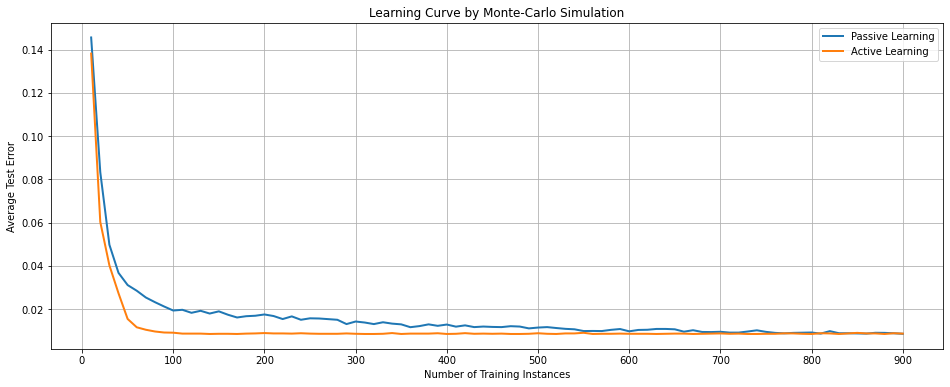

In [49]:
samples_num = list(range(10,910,10))
plt.figure(figsize=(16, 6))
plt.plot(samples_num, df_2bi.mean(),label='Passive Learning',linewidth=2)
plt.plot(samples_num, df_2bii.mean(),label='Active Learning',linewidth=2)
plt.legend(loc="upper right")
plt.xticks(list(range(0,1000,100)))
plt.title('Learning Curve by Monte-Carlo Simulation')
plt.ylabel('Average Test Error')
plt.xlabel('Number of Training Instances')
plt.grid()
plt.show()

<strong>Conclusion</strong><br>
In general, both learning methods performed are good when training pool is large.
Acitive learning performed better than Passive learning when data points less than around 800. They performed almost the same when the at the training pool sample size larger than 800 or smaller than 10. Then we can conclude for large datasets Active Learning and Passive Learning performances are the same for SVM model, if dataset is small Active Learning will be prefered.